In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from glob import glob
sys.path.append('..')

import metaflux
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(101)
torch.manual_seed(101)
import warnings
from tqdm import tqdm
import copy


import warnings
warnings.filterwarnings("ignore")

## Initializing

In [9]:
# Specify variables
xcolumns = ["P_ERA", "LAI", "VPD_ERA", "EVI"] # "P_ERA", "LAI", "SW_IN_F", "VPD_ERA", "TA_ERA", "EVI"
ycolumn = "RECO" # "GPP_NT_VUT_REF", "RECO"

# Load the hyperparameters for your task
config_path = '../metaflux/configs/fit.yaml'
hyper_args = metaflux.configs.get_hyperparams(config_path=config_path)

hyper_args['xcolumns'] = xcolumns
hyper_args['ycolumn'] = [ycolumn]
hyper_args['input_size'] = len(xcolumns)

# Load model
model_type = "mlp" # currently supported models: ['lstm', 'bilstm', 'mlp']

# Get data
root_dir = '../../Data/processed/tropics_full/'

# Note that the inputs are normalized here. For non-temporal data, we specify time_window = 1
fluxnet_train = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="train", x_columns=hyper_args["xcolumns"], y_column=ycolumn, context_columns=hyper_args["contextcolumns"] , time_column=None, time_window=1)
fluxnet_test = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="test", x_columns=hyper_args["xcolumns"], y_column=ycolumn, context_columns=hyper_args["contextcolumns"], time_column=None, time_window=1)

# Metalearning without encoding and with baseline
model = metaflux.learner.Learner(
    input_size=hyper_args["input_size"], 
    hidden_size=hyper_args["hidden_size"], 
    model_type=model_type, 
    fluxnet_train=fluxnet_train,
    fluxnet_test=fluxnet_test,
    update_lr=hyper_args["update_lr"],
    meta_lr=hyper_args["meta_lr"],
    batch_size=hyper_args["batch_size"],
    max_meta_step=hyper_args["max_meta_step"],
    finetune_size=hyper_args["finetune_size"],
    encoder_hidden_size=hyper_args["encoder_hidden_size"],
    with_context=False,
    with_baseline=True
)

# Metalearning with encodinh
model_enc = metaflux.learner.Learner(
    input_size=hyper_args["input_size"], 
    hidden_size=hyper_args["hidden_size"], 
    model_type=model_type, 
    fluxnet_train=fluxnet_train,
    fluxnet_test=fluxnet_test,
    update_lr=hyper_args["update_lr"],
    meta_lr=hyper_args["meta_lr"],
    batch_size=hyper_args["batch_size"],
    max_meta_step=hyper_args["max_meta_step"],
    finetune_size=hyper_args["finetune_size"],
    encoder_hidden_size=hyper_args["encoder_hidden_size"],
    with_context=True
)

In [4]:
def robustness_check(maml_c, maml, encoder, base, fluxnet, hyper_args, factor):
    def _get_pred(learner, encoder, x):
        # latent = learner(x[:,:,:hyper_args["input_size"]])
        "Subroutine to perform prediction on input x"
        if encoder != None:
            encoding = encoder(x[:,:,hyper_args["input_size"]:])
            learner.module.update_encoding(encoding)

        return learner(x[:,:,:hyper_args["input_size"]])

    def _get_robustness_data(x, y, factor):
        "For shifted, noisy, and extreme tests"
        shifted_x = x + factor # Shifted
        noisy_x = x + torch.normal(factor, 1 + factor) # Noisy

        # Extremes
        norm_y = (y - y.mean()) / y.std()
        xtr_mask = norm_y > factor
        xtr_x = x[xtr_mask.squeeze(),:,:]
        xtr_y = y[xtr_mask.squeeze(),:]

        return shifted_x, noisy_x, xtr_x, xtr_y

    db_test = DataLoader(fluxnet, batch_size=hyper_args["batch_size"], shuffle=True)
    learner_c = maml_c.clone().double()
    learner = maml.clone().double()
    meta_c_loss_dict, meta_loss_dict, base_loss_dict = dict(), dict(), dict()
    meta_c_shift_losses, meta_shift_losses, base_shift_losses = list(), list(), list()
    meta_c_noise_losses, meta_noise_losses, base_noise_losses = list(), list(), list()
    meta_c_xtr_losses, meta_xtr_losses, base_xtr_losses = list(), list(), list()


    for f in factor:
        meta_c_shift_loss, meta_shift_loss, base_shift_loss = 0.0, 0.0, 0.0
        meta_c_noise_loss, meta_noise_loss, base_noise_loss = 0.0, 0.0, 0.0
        meta_c_xtr_loss, meta_xtr_loss, base_xtr_loss = 0.0, 0.0, 0.0

        with torch.no_grad():
            for step, (x, y) in enumerate(db_test):
                x, y = x.to(device), y.to(device)
                shifted_x, noisy_x, xtr_x, xtr_y = _get_robustness_data(x, y, f)

                # Shifted
                meta_c_shift_loss += loss(_get_pred(learner_c, encoder=encoder, x=shifted_x), y).item()
                meta_shift_loss += loss(_get_pred(learner, encoder=None, x=shifted_x), y).item()
                base_shift_loss += loss(base(shifted_x[:,:,:hyper_args["input_size"]]), y).item()

                # Noisy
                meta_c_noise_loss += loss(_get_pred(learner_c, encoder=encoder, x=noisy_x), y).item()
                meta_noise_loss += loss(_get_pred(learner, encoder=None, x=noisy_x), y).item()
                base_noise_loss += loss(base(noisy_x[:,:,:hyper_args["input_size"]]), y).item()

                # Extreme
                meta_c_xtr_loss += loss(_get_pred(learner_c, encoder=encoder, x=xtr_x), xtr_y).item()
                meta_xtr_loss += loss(_get_pred(learner, encoder=None, x=xtr_x), xtr_y).item()
                base_xtr_loss += loss(base(xtr_x[:,:,:hyper_args["input_size"]]), xtr_y).item()
            
        meta_c_shift_losses.append(meta_c_shift_loss / (step + 1))
        meta_c_noise_losses.append(meta_c_noise_loss / (step + 1))
        meta_c_xtr_losses.append(meta_c_xtr_loss / (step + 1))
        meta_shift_losses.append(meta_shift_loss / (step + 1))
        meta_noise_losses.append(meta_noise_loss / (step + 1))
        meta_xtr_losses.append(meta_xtr_loss / (step + 1))
        base_shift_losses.append(base_shift_loss / (step + 1))
        base_noise_losses.append(base_noise_loss / (step + 1))
        base_xtr_losses.append(base_xtr_loss / (step + 1))

    meta_c_loss_dict.update({
        "shift": np.sqrt(np.array(meta_c_shift_losses)),
        "noise": np.sqrt(np.array(meta_c_noise_losses)),
        "xtr": np.sqrt(np.array(meta_c_xtr_losses))
    })

    meta_loss_dict.update({
        "shift": np.sqrt(np.array(meta_shift_losses)),
        "noise": np.sqrt(np.array(meta_noise_losses)),
        "xtr": np.sqrt(np.array(meta_xtr_losses))
    })

    base_loss_dict.update({
        "shift": np.sqrt(np.array(base_shift_losses)),
        "noise": np.sqrt(np.array(base_noise_losses)),
        "xtr": np.sqrt(np.array(base_xtr_losses))
    })

    return meta_c_loss_dict, meta_loss_dict, base_loss_dict

In [5]:
def extreme_analysis(maml_c, maml, encoder, base, hyper_args, data_dir, factor=1., is_plot=True):
    def _get_pred(learner, encoder, x):
        with_context = False if encoder == None else True
        "Subroutine to perform prediction on input x"
        if with_context:
            encoding = encoder(x)
            learner.module.update_encoding(encoding)

        return learner(x)

    def _get_extreme(x, y, y_norm, factor=factor):
        xtr_mask = y_norm > factor
        xtr_x = x[xtr_mask.squeeze()]
        xtr_y = y[xtr_mask.squeeze()]
        return torch.tensor(xtr_x).to(device), torch.tensor(xtr_y).to(device)

    learner_c = maml_c.clone().double()
    learner = maml.clone().double()

    # Get all csv data
    # TODO: abstract to util as read all csv
    modes = ["train", "test"]
    station_csv = list()
    for mode in modes:
        csvf = os.path.join(data_dir, mode)
        station_csv.extend(glob(f"{csvf}/*.csv"))

    # Compute y_norm for all stations
    all_df = []
    for station in station_csv:
        df = pd.read_csv(station)
        df = df.fillna(method="ffill").fillna(method="bfill")
        df.loc[:, df.columns.isin(hyper_args['xcolumns'])] = (df.loc[:, df.columns.isin(hyper_args['xcolumns'])] - df.loc[:, df.columns.isin(hyper_args['xcolumns'])].mean()) / df.loc[:, df.columns.isin(hyper_args['xcolumns'])].std()
        all_df.append(df)

    all_df = pd.concat(all_df).reset_index(drop=True)
    # TODO: normalize(df, xcolumns, ycolumn) function
    all_df[f"{hyper_args['ycolumn'][0]}_norm"] = (all_df[f"{hyper_args['ycolumn'][0]}"] - all_df[f"{hyper_args['ycolumn'][0]}"].mean()) / all_df[f"{hyper_args['ycolumn'][0]}"].std()

    # Analyze individual station
    extreme_under_df, extreme_over_df = list(), list()
    for i, station in all_df.groupby("Site"):
        x, y, y_norm = station[hyper_args['xcolumns']].to_numpy(), station[hyper_args['ycolumn']].to_numpy(), station[[f"{hyper_args['ycolumn'][0]}_norm"]].to_numpy()
        x, y = _get_extreme(x, y, y_norm)

        maml_pred = _get_pred(learner, encoder=None, x=x)
        base_pred = base(x)

        try:
            extreme_under_d = {
                "climate": station["Climate"].iloc[0],
                "lon": station["Lon"].iloc[0],
                "lat": station["Lat"].iloc[0],
                "y": y.mean().item(),
                "base_under_prop": len(base_pred[base_pred < y]) / len(base_pred), 
                "maml_under_prop": len(maml_pred[maml_pred < y]) / len(maml_pred), 
                "base_under_mean": abs(base_pred[base_pred < y] - y[base_pred < y]).mean().item(),
                "maml_under_mean": abs(maml_pred[maml_pred < y] - y[maml_pred < y]).mean().item(),
            }

            extreme_over_d = {
                "climate": station["Climate"].iloc[0],
                "lon": station["Lon"].iloc[0],
                "lat": station["Lat"].iloc[0],
                "y": y.mean().item(),
                "base_over_prop": len(base_pred[base_pred > y]) / len(base_pred), 
                "base_over_mean": abs(base_pred[base_pred > y] - y[base_pred > y]).mean().item(),
                "maml_over_mean": abs(maml_pred[maml_pred > y] - y[maml_pred > y]).mean().item(),
            }

        except:
            continue
        
        extreme_under_df.append(extreme_under_d)
        extreme_over_df.append(extreme_over_d)
    
    extreme_under_df = pd.DataFrame(extreme_under_df)
    extreme_over_df = pd.DataFrame(extreme_over_df)
    extreme_under_df.dropna(subset=("maml_under_mean", "base_under_mean"), inplace=True)
    extreme_over_df.dropna(subset=("maml_over_mean", "base_over_mean"), inplace=True)

    if is_plot:
        f, ax = plt.subplots(figsize=(16,12))
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        gdf = gpd.GeoDataFrame(extreme_under_df, geometry=gpd.points_from_xy(extreme_under_df.lon, extreme_under_df.lat))
        val_mean = int(gdf["base_under_mean"].mean())
        val_std = max(2*int(gdf["base_under_mean"].std()), 1)
        
        markersize_maml = np.exp(gdf['maml_under_mean']/2)
        markersize_base = np.exp(gdf['base_under_mean']/2)

        gdf.plot(markersize=markersize_maml, alpha=0.5, ax=ax, zorder=10)
        gdf.plot(markersize=markersize_base, alpha=0.5, ax=ax, zorder=5)
        world.boundary.plot(color="grey", linewidth=0.5, alpha=0.5, ax=ax, zorder=0)
        ax.set_ylim(-60,90)
        ax.axis("off")

        ax.scatter([], [], c='#1f77b4', alpha=0.5, s=100, label="Metalearning")
        ax.scatter([], [], c='orange', alpha=0.5, s=100, label="Non-Metalearning")
        ax.scatter([], [], c='xkcd:silver', alpha=1, s=np.exp((val_mean - val_std)/2), label=f'MAE < {val_mean - val_std}', edgecolor='black')
        ax.scatter([], [], c='xkcd:silver', alpha=1, s=np.exp((val_mean)/2), label=f'MAE {val_mean - val_std} - {val_mean + val_std}', edgecolor='black')
        ax.scatter([], [], c='xkcd:silver', alpha=1, s=np.exp((val_mean + val_std)/2), label=f'MAE > {val_mean + val_std}', edgecolor='black')

        ax.legend(title="MAE for underestimating\n extremes ($gCm^{-2}d^{-1}$)", labelspacing=1.5, borderpad=1, fontsize=8, title_fontsize=10, loc="lower left");

    return extreme_under_df, extreme_over_df
        
        

## GPP

Baseline loss: 5.31 ± 0.00
Meta-learning without context loss: 3.61 ± 0.00
Meta-learning with context loss: 3.42 ± 0.00


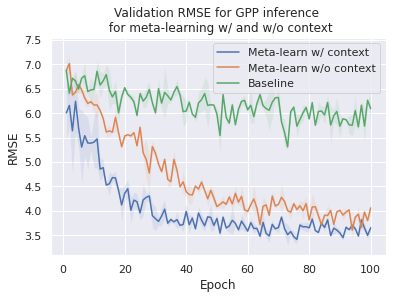

In [6]:
runs = 2
model.train_meta(runs=runs, epochs=hyper_args["epoch"])
model_enc.train_meta(runs=runs, epochs=hyper_args["epoch"])

# Plot validation loss
is_smoothing = False
smoothing_exp = 7
f, ax = plt.subplots()
epochs = np.arange(1,hyper_args["epoch"] + 1)
meta_c_loss, meta_loss, base_loss = list(), list(), list()
for run in range(runs):
    meta_c_loss.append(model_enc.meta_loss_metric[f"val_epoch_{run}"])
    meta_loss.append(model.meta_loss_metric[f"val_epoch_{run}"])
    base_loss.append(model.base_loss_metric[f"val_epoch_{run}"])

meta_c_loss = np.array(meta_c_loss)
meta_loss = np.array(meta_loss)
base_loss = np.array(base_loss)
if is_smoothing:
    meta_c_mean = np.poly1d(np.polyfit(epochs, meta_c_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_c_std = np.poly1d(np.polyfit(epochs, meta_c_loss.std(axis=0), smoothing_exp))(epochs)
    meta_mean = np.poly1d(np.polyfit(epochs, meta_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_std = np.poly1d(np.polyfit(epochs, meta_loss.std(axis=0), smoothing_exp))(epochs)
    base_mean = np.poly1d(np.polyfit(epochs, base_loss.mean(axis=0), smoothing_exp))(epochs)
    base_std = np.poly1d(np.polyfit(epochs, base_loss.std(axis=0), smoothing_exp))(epochs)
else:
    meta_c_mean = meta_c_loss.mean(axis=0)
    meta_c_std = meta_c_loss.std(axis=0)
    meta_mean = meta_loss.mean(axis=0)
    meta_std = meta_loss.std(axis=0)
    base_mean = base_loss.mean(axis=0)
    base_std = base_loss.std(axis=0)

ax.plot(epochs, meta_c_mean, label='Meta-learn w/ context')
ax.plot(epochs, meta_mean, label='Meta-learn w/o context')
ax.plot(epochs, base_mean, label='Baseline')
ax.fill_between(epochs, meta_c_mean - meta_c_std, meta_c_mean + meta_c_std, alpha=0.1)
ax.fill_between(epochs, meta_mean - meta_std, meta_mean + meta_std, alpha=0.1)
ax.fill_between(epochs, base_mean - base_std, base_mean + base_std, alpha=0.1)
ax.set_title("Validation RMSE for GPP inference \n for meta-learning w/ and w/o context")
ax.set_ylabel("RMSE")
ax.set_xlabel("Epoch")
ax.legend()

print(f"Baseline loss: {min(base_loss.mean(axis=0)):.2f} ± {min(base_loss.std(axis=0)):.2f}")
print(f"Meta-learning without context loss: {min(meta_loss.mean(axis=0)):.2f} ± {min(meta_loss.std(axis=0)):.2f}")
print(f"Meta-learning with context loss: {min(meta_c_loss.mean(axis=0)):.2f} ± {min(meta_c_loss.std(axis=0)):.2f}")

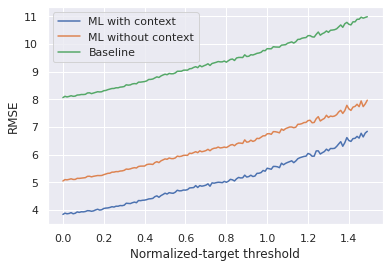

In [7]:
factor = torch.arange(0.0, 1.5, 0.01)
meta_c_loss, meta_loss, base_loss = robustness_check(model_enc.maml, model.maml, model_enc.encoder, model.base_model, fluxnet_test, hyper_args, factor)

f, ax = plt.subplots()
robust_check = "xtr"
ax.plot(factor, meta_c_loss[robust_check], label="ML with context")
ax.plot(factor, meta_loss[robust_check], label="ML without context")
ax.plot(factor, base_loss[robust_check], label="Baseline")
ax.set_ylabel("RMSE")
ax.set_xlabel("Normalized-target threshold")
plt.legend()

,lon,lat,y,base_under_prop,maml_under_prop,base_under_mean,maml_under_mean
climate,,,,,,,
Arctic,8.537780,47.115830,11.523678,1.0,1.0,10.497297,6.687228
Arid,19.587693,-17.510807,11.343264,1.0,1.0,10.418463,6.942039
Continental,-33.718067,47.579079,11.399265,1.0,1.0,10.459856,7.033668
Temperate,-22.623578,37.998112,11.349552,1.0,1.0,10.487538,7.303121
Tropical,7.671452,-1.934708,10.396634,1.0,1.0,9.537586,6.065222


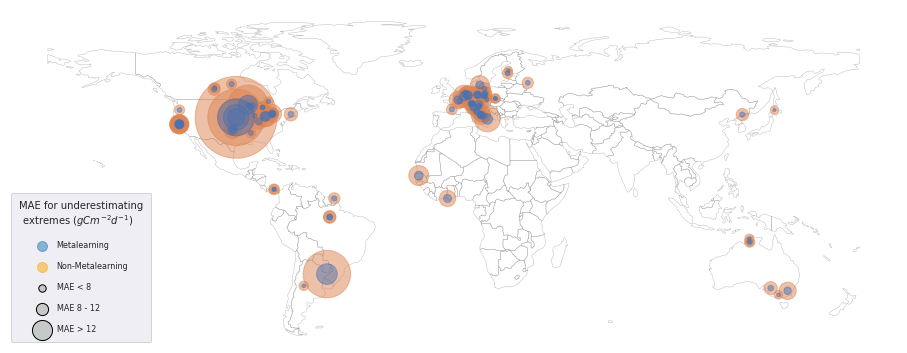

In [8]:
extreme_under_df, extreme_over_df = extreme_analysis(model_enc.maml, model.maml, model_enc.encoder, model.base_model, hyper_args, data_dir="../../Data/processed/tropics_full/", factor=1.5, is_plot=True)
extreme_under_df.groupby("climate").mean()

In [9]:
PATH = f"../../model_dir/maml_{model_type}_{ycolumn}.pt"
torch.save(model.maml, PATH)

## Reco

Baseline loss: 4.98 ± 0.00
Meta-learning without context loss: 3.32 ± 0.00
Meta-learning with context loss: 3.20 ± 0.00


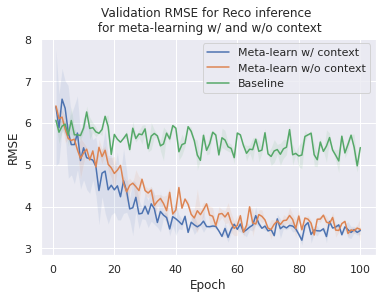

In [10]:
runs = 2
model.train_meta(runs=runs, epochs=hyper_args["epoch"])
model_enc.train_meta(runs=runs, epochs=hyper_args["epoch"])

# Plot validation loss
is_smoothing = False
smoothing_exp = 7
f, ax = plt.subplots()
epochs = np.arange(1,hyper_args["epoch"] + 1)
meta_c_loss, meta_loss, base_loss = list(), list(), list()
for run in range(runs):
    meta_c_loss.append(model_enc.meta_loss_metric[f"val_epoch_{run}"])
    meta_loss.append(model.meta_loss_metric[f"val_epoch_{run}"])
    base_loss.append(model.base_loss_metric[f"val_epoch_{run}"])

meta_c_loss = np.array(meta_c_loss)
meta_loss = np.array(meta_loss)
base_loss = np.array(base_loss)
if is_smoothing:
    meta_c_mean = np.poly1d(np.polyfit(epochs, meta_c_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_c_std = np.poly1d(np.polyfit(epochs, meta_c_loss.std(axis=0), smoothing_exp))(epochs)
    meta_mean = np.poly1d(np.polyfit(epochs, meta_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_std = np.poly1d(np.polyfit(epochs, meta_loss.std(axis=0), smoothing_exp))(epochs)
    base_mean = np.poly1d(np.polyfit(epochs, base_loss.mean(axis=0), smoothing_exp))(epochs)
    base_std = np.poly1d(np.polyfit(epochs, base_loss.std(axis=0), smoothing_exp))(epochs)
else:
    meta_c_mean = meta_c_loss.mean(axis=0)
    meta_c_std = meta_c_loss.std(axis=0)
    meta_mean = meta_loss.mean(axis=0)
    meta_std = meta_loss.std(axis=0)
    base_mean = base_loss.mean(axis=0)
    base_std = base_loss.std(axis=0)

ax.plot(epochs, meta_c_mean, label='Meta-learn w/ context')
ax.plot(epochs, meta_mean, label='Meta-learn w/o context')
ax.plot(epochs, base_mean, label='Baseline')
ax.fill_between(epochs, meta_c_mean - meta_c_std, meta_c_mean + meta_c_std, alpha=0.1)
ax.fill_between(epochs, meta_mean - meta_std, meta_mean + meta_std, alpha=0.1)
ax.fill_between(epochs, base_mean - base_std, base_mean + base_std, alpha=0.1)
ax.set_title("Validation RMSE for Reco inference \n for meta-learning w/ and w/o context")
ax.set_ylabel("RMSE")
ax.set_xlabel("Epoch")
ax.legend()

print(f"Baseline loss: {min(base_loss.mean(axis=0)):.2f} ± {min(base_loss.std(axis=0)):.2f}")
print(f"Meta-learning without context loss: {min(meta_loss.mean(axis=0)):.2f} ± {min(meta_loss.std(axis=0)):.2f}")
print(f"Meta-learning with context loss: {min(meta_c_loss.mean(axis=0)):.2f} ± {min(meta_c_loss.std(axis=0)):.2f}")

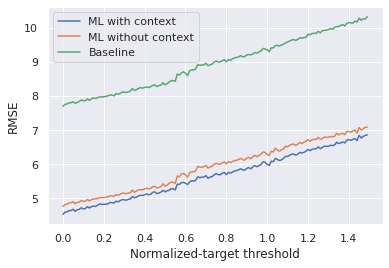

In [11]:
factor = torch.arange(0.0, 1.5, 0.01)
meta_c_loss, meta_loss, base_loss = robustness_check(model_enc.maml, model.maml, model_enc.encoder, model.base_model, fluxnet_test, hyper_args, factor)

f, ax = plt.subplots()
robust_check = "xtr"
ax.plot(factor, meta_c_loss[robust_check], label="ML with context")
ax.plot(factor, meta_loss[robust_check], label="ML without context")
ax.plot(factor, base_loss[robust_check], label="Baseline")
ax.set_ylabel("RMSE")
ax.set_xlabel("Normalized-target threshold")
plt.legend()

,lon,lat,y,base_under_prop,maml_under_prop,base_under_mean,maml_under_mean
climate,,,,,,,
Arctic,9.196845,46.965580,8.138574,1.0,1.000000,7.275292,3.263744
Arid,-15.432220,15.402780,8.171090,1.0,1.000000,7.202627,2.895714
Continental,-44.486745,47.751147,8.243088,1.0,0.983862,7.485503,3.987857
Temperate,-28.563287,38.517854,8.264511,1.0,0.997519,7.523590,4.147847
Tropical,9.450181,-3.376422,8.070529,1.0,0.993549,7.365488,4.334907


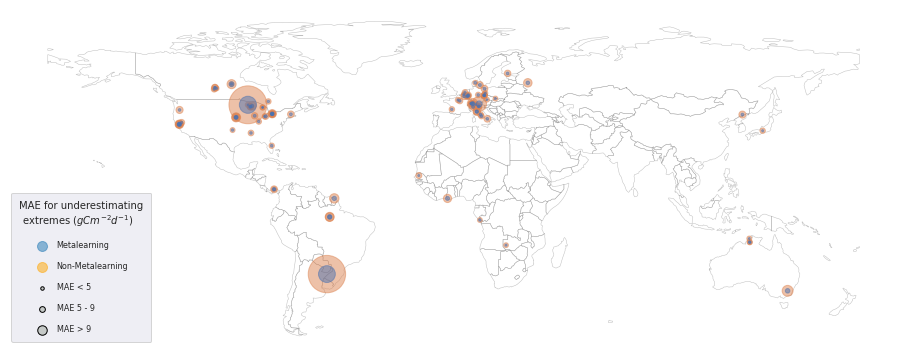

In [12]:
extreme_under_df, extreme_over_df = extreme_analysis(model_enc.maml, model.maml, model_enc.encoder, model.base_model, hyper_args, data_dir="../../Data/processed/tropics_full/", factor=1.5, is_plot=True)
extreme_under_df.groupby("climate").mean()

In [12]:
PATH = f"../../model_dir/maml_{model_type}_{ycolumn}.pt"
torch.save(model.maml, PATH)